<a href="https://colab.research.google.com/github/xb24/1-year-mortality-prediction/blob/main/1-year-mortality-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BME 590： Data Science and Health --- Final Project
### Xiaoke Bi, Zhixiong (Jack) Li, Zhe (Wade) Wei, Rui Yang

## Background and Overview

Long-term mortality is one of the key metrics for assessing continuity of care and severity of dieseases at the population level, wherein the health outcomes of patients are often tracked for 6 month or 1 year after receiving medical care. At patient's level, a reliable 1-year mortality prediction allows health care providers to give patients specialized course of action. Over the past dacades, several clinical risk scores have been introduced to predict patients' mortality. Early risk scores mostly relied upon subjective or statistical methods. Such methods either require clinicians' expertise or impose stringent constraints on the relationship between variables and outcomes. For example, the most widely-used logistic regression model relies on the assumption of a linear and additive relationship between variables and mortality, largely underestimating the complexity of a realistic mortality prediction model. More recently, machine learning approaches, driven by health and clinical database such as MIMIC, give rise to more precise and accurate mortality prediction models that take into account the complex nature of disease mortality. Here, we developed a machine learning-based model for 1-year mortality prediction using MIMIC-III database.

## Data

In [ ]:
# Download MIMIC III data from physionet.org
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/PATIENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/D_ICD_DIAGNOSES.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/MICROBIOLOGYEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/PROCEDUREEVENTS_MV.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/CPTEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/DATETIMEEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/LABEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/OUTPUTEVENTS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/PRESCRIPTIONS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/ICUSTAYS.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/DIAGNOSES_ICD.csv.gz
!wget -r -N -c -np --user zl277@duke.edu --ask-password https://physionet.org/files/mimiciii/1.4/D_ITEMS.csv.gz

Password for user ‘zl277@duke.edu’: 
--2021-04-29 15:00:24--  https://physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="PhysioNet", charset="UTF-8"
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 2525254 (2.4M) [application/gzip]
Saving to: ‘physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz’

physionet.org/files 100%[===================>]   2.41M  1.26MB/s    in 1.9s    

2021-04-29 15:00:27 (1.26 MB/s) - ‘physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz’ saved [2525254/2525254]

FINISHED --2021-04-29 15:00:27--
Total wall clock time: 8.8s
Downloaded: 1 files, 2.4M in 1.9s (1.26 MB/s)
Password for user ‘zl277@duke.edu’: 
--2021-04-29 15:00:32--  https://physionet.org/files/mimiciii/1.4/DIAGNOSES_ICD.csv.g

## Exploratory Data Analysis

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import torch
from torch import nn
from google.colab import files
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# Read data from csv files and import into dataframes
admissions_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz')
diagnosis_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/DIAGNOSES_ICD.csv.gz')
patient_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/PATIENTS.csv.gz')
code_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/D_ICD_DIAGNOSES.csv.gz')
microbio_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/MICROBIOLOGYEVENTS.csv.gz')
item_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/D_ITEMS.csv.gz')
procedureevents_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/PROCEDUREEVENTS_MV.csv.gz')
CPT_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/CPTEVENTS.csv.gz')
daytime_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/DATETIMEEVENTS.csv.gz')
labevents_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/LABEVENTS.csv.gz')
noteevents_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz')
outputevents_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/OUTPUTEVENTS.csv.gz')
prescriptions_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/PRESCRIPTIONS.csv.gz')
ICU_df = pd.read_csv('/content/physionet.org/files/mimiciii/1.4/ICUSTAYS.csv.gz')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


To better understand the MIMIC-III database, we performed a series of exploratory data analysis to preliminarily determine features that are important for 1 year mortality. To start with, we assumed that the time a certain patient spent in hospital is inversely proportional to 1 year mortality. We first divided admission encounters into two groups: (1) encounters that died within 1 year after admission, and (2) encounters that survived 1 year after admission. For both groups, the number of counts decrease as the length of stay in hospital increase (Fig. 1). Therefore, our assumption was proved reasonable.

In [ ]:
# Merge dataframes and calculate 1-yr-mortality from datasets
mortality = pd.merge(admissions_df, patient_df, how='left', on='SUBJECT_ID')
mortality[['ADMITTIME','DOD']] = mortality[['ADMITTIME','DOD']].apply(pd.to_datetime)
mortality['1_yr_mortality'] = ((mortality['DOD'] - mortality['ADMITTIME']).dt.days<365)*1
admissions_df['1_yr_mortality'] = mortality['1_yr_mortality']

In [ ]:
admissions_df[['ADMITTIME','DISCHTIME']] = admissions_df[['ADMITTIME','DISCHTIME']].apply(pd.to_datetime)
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days
admissions_df[['ADMITTIME','DEATHTIME']] = admissions_df[['ADMITTIME','DEATHTIME']].apply(pd.to_datetime)
subset_1_yr_mortality = admissions_df.loc[(admissions_df['1_yr_mortality'] == 1)]
subset_na_mortality = admissions_df.loc[(admissions_df['1_yr_mortality'] == 0)]


Text(0, 0.5, 'number_of_encounters')

<Figure size 432x288 with 0 Axes>

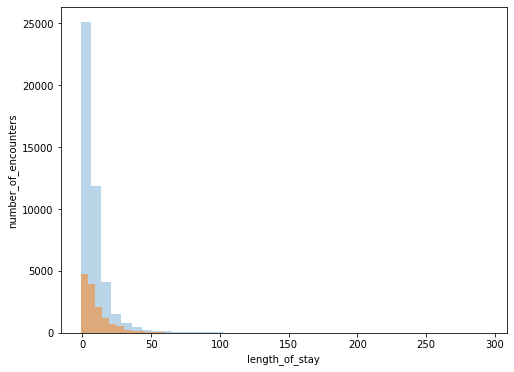

In [ ]:
# Figure 1: Explore relationship between length of stay and number of encounters
plt.figure(1)
plt.figure(figsize=(8,6))

plt.hist(subset_na_mortality['length_of_stay'].values, bins=40, alpha=0.3)
plt.hist(subset_1_yr_mortality['length_of_stay'].values, bins=40, alpha=0.5)

plt.xlabel('length_of_stay')
plt.ylabel('number_of_encounters')

Figure 1.  A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different ranges of time spent in hospital.

Next, we explored the distribution of 1 year mortality over different types of admissions. For both groups, most admission encounters are emergency, followed by elective and urgent. Notably, a large proportion of encounters with 1 year survival are newborn admission, whereas almost no 1 year mortality is associated with newborn admission (Fig. 2). Given the different pattern of distribution, we anticipated that admission type is an important feature that we might want to take into account.

Text(0, 0.5, 'number_of_encounters')

<Figure size 432x288 with 0 Axes>

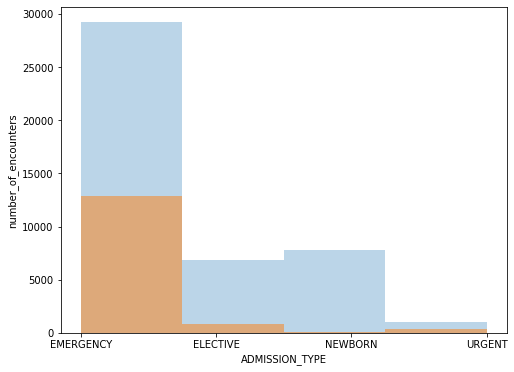

In [ ]:
# Figure 1: Explore relationship between number of encounters and admission types
plt.figure(2)
plt.figure(figsize=(8,6))

plt.hist(subset_na_mortality['ADMISSION_TYPE'].values, bins=4, alpha=0.3)
plt.hist(subset_1_yr_mortality['ADMISSION_TYPE'].values, bins=4, alpha=0.5)

plt.xlabel('ADMISSION_TYPE')
plt.ylabel('number_of_encounters')

Figure 2. A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different types of admission.

Then, we explored the distribution of 1 year mortality over different ranges of number of diagnosis. Notably, the histogram shape of 1 year mortality and 1 year survival is very similar (Fig. 3a). In this case, we assumed that the number of diagnosis of certain encounters might not be an important feature. To preliminarily prove this assumption, we plotted the time spent in hospital versus number of diagnosis and plotted a linear regression line, using the 1 year mortality group (Fig. 3b). Consistent with our assumption, the scatter plot shows a very poor linear relationship.

Text(0, 0.5, 'length_of_stay')

<Figure size 432x288 with 0 Axes>

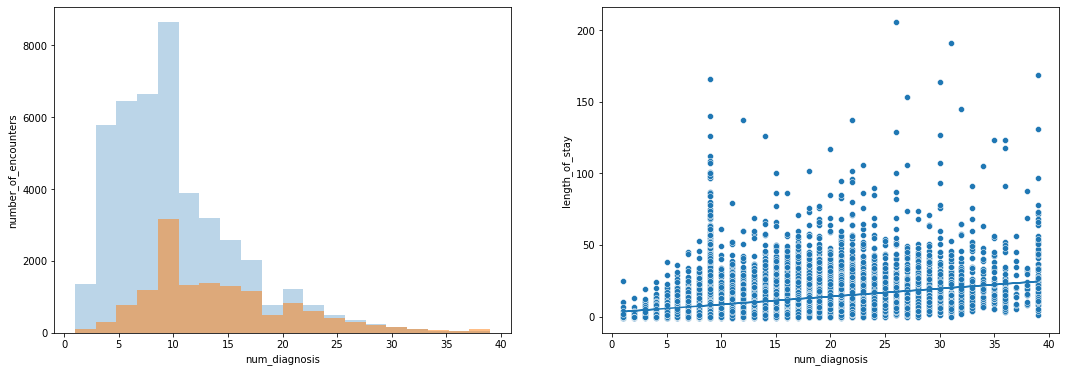

In [ ]:
# Figure 3: Exploratory Data Analysis between number of encounters, length of stay and number of diagnosis
num_diagnosis = diagnosis_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_diagnosis')
subset_na_mortality = pd.merge(subset_na_mortality, num_diagnosis, how='inner', on='HADM_ID')
subset_1_yr_mortality = pd.merge(subset_1_yr_mortality, num_diagnosis, how='inner', on='HADM_ID')
plt.figure(3)
plt.figure(figsize=(18,6))

# Subplot 1
plt.subplot(121)
plt.hist(subset_na_mortality['num_diagnosis'].values, bins=20, alpha=0.3)
plt.hist(subset_1_yr_mortality['num_diagnosis'].values, bins=20, alpha=0.5)
plt.xlabel('num_diagnosis')
plt.ylabel('number_of_encounters')

# Subplot 2
plt.subplot(122)
sns.scatterplot(x = 'num_diagnosis', y = 'length_of_stay', data = subset_1_yr_mortality)
x=subset_1_yr_mortality['num_diagnosis'].values
y=subset_1_yr_mortality['length_of_stay'].values
m, b = np.polyfit(x, y, 1)

# Add linear regression line to scatterplot
plt.plot(x, m*x+b)
plt.xlabel('num_diagnosis')
plt.ylabel('length_of_stay')

Figure 3. (a) A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different ranges of number of diagnosis. (b) A scatter plot of time spent in hospital versus number of diagnosis

Based on the same logic, we further looked into the number of prescription, labevents and the time spent in ICU as features of 1 year mortality prediction model. We found that the number of prescription and labevents are linearly related to the time spent in hospital, meaning that they are important features (Fig. 4 and 5). Surprisingly, the time spent in ICU shows a poor linear relationship with time spent in hospital (Fig. 6).

Text(0, 0.5, 'length_of_stay')

<Figure size 432x288 with 0 Axes>

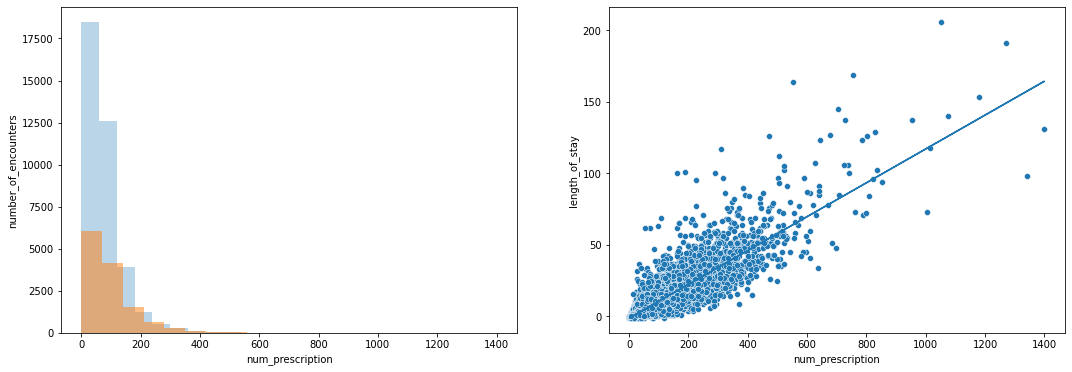

In [ ]:
# Figure 4: Exploratory Data Analysis between number of encounters, length of stay and number of prescription
num_prescription = prescriptions_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_prescription')
subset_na_mortality = pd.merge(subset_na_mortality, num_prescription, how='inner', on='HADM_ID')
subset_1_yr_mortality = pd.merge(subset_1_yr_mortality, num_prescription, how='inner', on='HADM_ID')
plt.figure(4)
plt.figure(figsize=(18,6))

# Subplot 1
plt.subplot(121)
plt.hist(subset_na_mortality['num_prescription'].values, bins=20, alpha=0.3)
plt.hist(subset_1_yr_mortality['num_prescription'].values, bins=20, alpha=0.5)
plt.xlabel('num_prescription')
plt.ylabel('number_of_encounters')

# Subplot 2
plt.subplot(122)
sns.scatterplot(x = 'num_prescription', y = 'length_of_stay', data = subset_1_yr_mortality)
x=subset_1_yr_mortality['num_prescription'].values
y=subset_1_yr_mortality['length_of_stay'].values
m, b = np.polyfit(x, y, 1)

# Add linear regression line to scatterplot
plt.plot(x, m*x+b)
plt.xlabel('num_prescription')
plt.ylabel('length_of_stay')

Figure 4. (a) A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different ranges of number of prescription. (b) A scatter plot of time spent in hospital versus number of prescription.

Text(0, 0.5, 'length_of_stay')

<Figure size 432x288 with 0 Axes>

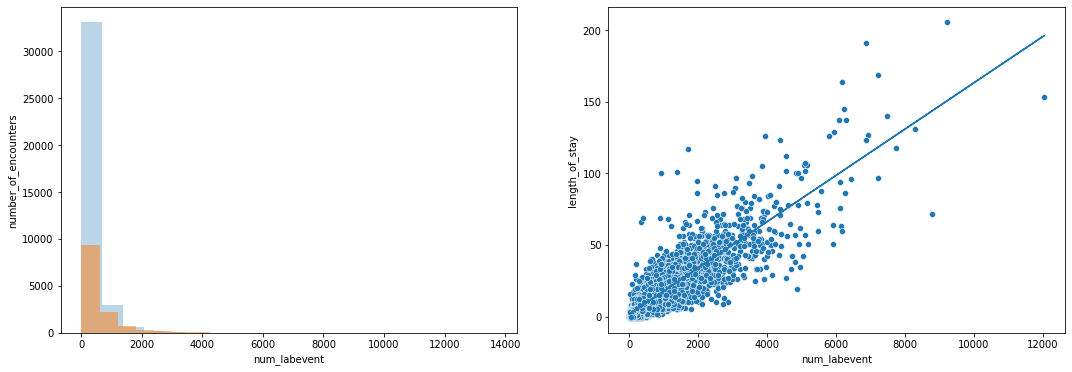

In [ ]:
# Figure 5: Exploratory Data Analysis between number of encounters, length of stay and number of labevent
num_labevent = labevents_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_labevent')
subset_na_mortality = pd.merge(subset_na_mortality, num_labevent, how='inner', on='HADM_ID')
subset_1_yr_mortality = pd.merge(subset_1_yr_mortality, num_labevent, how='inner', on='HADM_ID')
plt.figure(4)
plt.figure(figsize=(18,6))

# Subplot 1
plt.subplot(121)
plt.hist(subset_na_mortality['num_labevent'].values, bins=20, alpha=0.3)
plt.hist(subset_1_yr_mortality['num_labevent'].values, bins=20, alpha=0.5)
plt.xlabel('num_labevent')
plt.ylabel('number_of_encounters')

# Subplot 2
plt.subplot(122)
sns.scatterplot(x = 'num_labevent', y = 'length_of_stay', data = subset_1_yr_mortality)
x=subset_1_yr_mortality['num_labevent'].values
y=subset_1_yr_mortality['length_of_stay'].values
m, b = np.polyfit(x, y, 1)

# Add linear regression line to scatterplot
plt.plot(x, m*x+b)
plt.xlabel('num_labevent')
plt.ylabel('length_of_stay')

Figure 5. (a) A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different ranges of number of labevents. (b) A scatter plot of time spent in hospital versus number of labevents.

Text(0, 0.5, 'length_of_stay')

<Figure size 432x288 with 0 Axes>

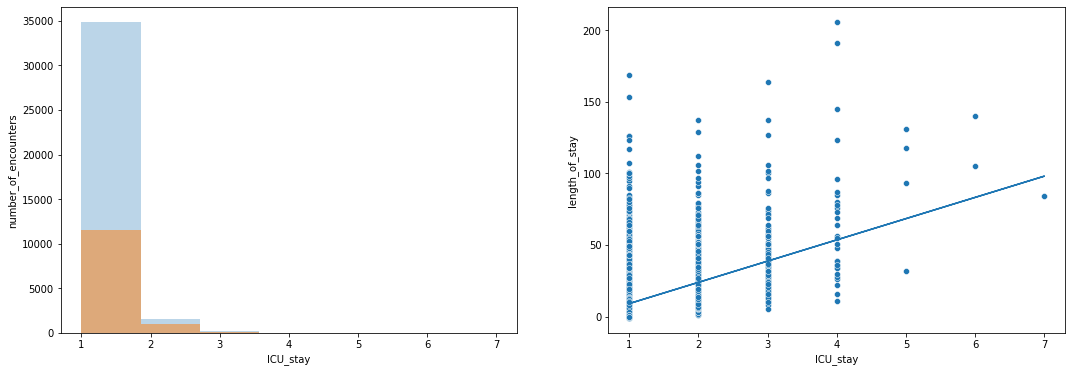

In [ ]:
# Figure 6: Exploratory Data Analysis between number of encounters, length of stay and ICU stays
ICU_stay = ICU_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='ICU_stay')
subset_na_mortality = pd.merge(subset_na_mortality, ICU_stay, how='inner', on='HADM_ID')
subset_1_yr_mortality = pd.merge(subset_1_yr_mortality, ICU_stay, how='inner', on='HADM_ID')
plt.figure(4)
plt.figure(figsize=(18,6))

# Subplot 1
plt.subplot(121)
plt.hist(subset_na_mortality['ICU_stay'].values, bins=7, alpha=0.3)
plt.hist(subset_1_yr_mortality['ICU_stay'].values, bins=7, alpha=0.5)
plt.xlabel('ICU_stay')
plt.ylabel('number_of_encounters')

# Subplot 2
plt.subplot(122)
sns.scatterplot(x = 'ICU_stay', y = 'length_of_stay', data = subset_1_yr_mortality)
x=subset_1_yr_mortality['ICU_stay'].values
y=subset_1_yr_mortality['length_of_stay'].values
m, b = np.polyfit(x, y, 1)

# Add linear regression line to scatterplot
plt.plot(x, m*x+b)
plt.xlabel('ICU_stay')
plt.ylabel('length_of_stay')

Figure 6. (a) A histogram showing the number of encounters that died within 1 year after admission (orange) and that survived 1 year after admission (blue) over different ranges of time spent in ICU. (b) A scatter plot of time spent in hospital versus time spent in ICU.

## Modeling

### Model Matrix

In [ ]:
def get_model_matrix():

    """
    Extract essential features from datasets

    Parameters
    ----------
    None

    Returns
    -------
    model_matrix: pd.dataframe
        contains matrix for model training
    """

  mortality = pd.merge(admissions_df, patient_df, how='left', on='SUBJECT_ID')
  mortality[['ADMITTIME','DOD']] = mortality[['ADMITTIME','DOD']].apply(pd.to_datetime)
  mortality['1_yr_mortality'] = ((mortality['DOD'] - mortality['ADMITTIME']).dt.days<365)*1
  mortality = mortality[['HADM_ID','1_yr_mortality']]

  admission_type = admissions_df.replace({'ADMISSION_TYPE' : { 'EMERGENCY' : 1, 'ELECTIVE' : 2, 'NEWBORN' : 3, 'URGENT' : 4}})
  admission_type = admission_type[['HADM_ID', 'ADMISSION_TYPE']]

  gender = pd.merge(admissions_df, patient_df, how='left', on='SUBJECT_ID')
  gender = gender.replace({'GENDER' : { 'M' : 1, 'F' : 0}})
  gender = gender[['HADM_ID', 'GENDER']]

  marital_status = admissions_df.replace({'MARITAL_STATUS' : { 'MARRIED' : 1, 'SINGLE' : 2, 'DIVORCED' : 3, 'WIDOWED' : 4, 'SEPARATED' : 5, 'UNKNOWN (DEFAULT)' : 0, 'LIFE PARTNER' : 6}})
  marital_status = marital_status[['HADM_ID', 'MARITAL_STATUS']]

  num_procedureevent = procedureevents_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_procedureevent')
  num_microbioevent = microbio_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_microbioevent')
  num_diagnosis = diagnosis_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_diagnosis')

  num_cptevent = CPT_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_cptevent')
  num_cptevent['HADM_ID'] = num_cptevent['HADM_ID'].astype(int)

  num_daytimeevent = daytime_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_daytimeevent')
  num_daytimeevent['HADM_ID'] = num_daytimeevent['HADM_ID'].astype(int)

  num_labevent = labevents_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_labevent')
  num_labevent['HADM_ID'] = num_labevent['HADM_ID'].astype(int)

  num_noteevent = noteevents_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_noteevent')
  num_noteevent['HADM_ID'] = num_noteevent['HADM_ID'].astype(int)

  num_outputevent = outputevents_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_outputevent')
  num_outputevent['HADM_ID'] = num_outputevent['HADM_ID'].astype(int)

  num_prescription = prescriptions_df['HADM_ID'].value_counts().rename_axis('HADM_ID').reset_index(name='num_prescription')

  ICU_df[['INTIME','OUTTIME']] = ICU_df[['INTIME','OUTTIME']].apply(pd.to_datetime)
  ICU_df['ICU_stay'] = (ICU_df['OUTTIME'] - ICU_df['INTIME']).dt.days
  ICU_stay = ICU_df[['HADM_ID','ICU_stay']]
  ICU_stay = ICU_stay.groupby('HADM_ID', sort=False).sum().reset_index()

  admissions_df[['DISCHTIME','ADMITTIME']] = admissions_df[['DISCHTIME','ADMITTIME']].apply(pd.to_datetime)
  admissions_df['hospital_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days
  length_of_stay = admissions_df[['HADM_ID','length_of_stay']]

  # model merge
  model_matrix = pd.merge(mortality, num_diagnosis, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, admission_type, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, gender, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, marital_status, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, ICU_stay, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, length_of_stay, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_prescription, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_procedureevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_microbioevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_cptevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_daytimeevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_labevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_noteevent, how='left', on='HADM_ID')
  model_matrix = pd.merge(model_matrix, num_outputevent, how='left', on='HADM_ID')
  model_matrix = model_matrix.replace(np.nan, 0)
  model_matrix.drop('HADM_ID', inplace=True, axis=1)
  cols = list(model_matrix.columns)
  cols = cols[1:-1] + [cols[0]]
  model_matrix = model_matrix[cols]

  return model_matrix

In [ ]:
# Display the matrix
model_matrix = get_model_matrix()
model_matrix

,num_diagnosis,ADMISSION_TYPE,GENDER,MARITAL_STATUS,ICU_stay,length_of_stay,num_prescription,num_procedureevent,num_microbioevent,num_cptevent,num_daytimeevent,num_labevent,num_noteevent,1_yr_mortality
0,7,1,0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,91.0,10.0,0
1,8,2,1,1.0,1.0,5,69.0,0.0,1.0,0.0,3.0,208.0,12.0,0
2,10,1,1,1.0,1.0,6,69.0,4.0,1.0,6.0,15.0,221.0,17.0,0
3,4,1,1,2.0,0.0,2,26.0,0.0,0.0,4.0,0.0,99.0,5.0,0
4,4,1,1,1.0,3.0,3,67.0,0.0,2.0,4.0,2.0,315.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,8,1,0,2.0,0.0,2,78.0,6.0,1.0,5.0,12.0,140.0,9.0,0
58972,4,1,0,4.0,0.0,0,8.0,3.0,1.0,0.0,6.0,55.0,1.0,1
58973,17,2,1,1.0,1.0,8,72.0,9.0,6.0,6.0,53.0,300.0,26.0,0
58974,9,1,0,1.0,8.0,41,175.0,0.0,24.0,19.0,0.0,523.0,25.0,0


In [ ]:
# Save matrix locally
model_matrix.to_csv("model_matrix.csv")
files.download('model_matrix.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
saved_df = pd.read_csv('model_matrix.csv')
saved_df.iloc[:,1:None]

,num_diagnosis,ADMISSION_TYPE,GENDER,MARITAL_STATUS,ICU_stay,length_of_stay,num_prescription,num_procedureevent,num_microbioevent,num_cptevent,num_daytimeevent,num_labevent,num_noteevent,1_yr_mortality
0,7,1,0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,91.0,10.0,0
1,8,2,1,1.0,1.0,5,69.0,0.0,1.0,0.0,3.0,208.0,12.0,0
2,10,1,1,1.0,1.0,6,69.0,4.0,1.0,6.0,15.0,221.0,17.0,0
3,4,1,1,2.0,0.0,2,26.0,0.0,0.0,4.0,0.0,99.0,5.0,0
4,4,1,1,1.0,3.0,3,67.0,0.0,2.0,4.0,2.0,315.0,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,8,1,0,2.0,0.0,2,78.0,6.0,1.0,5.0,12.0,140.0,9.0,0
58972,4,1,0,4.0,0.0,0,8.0,3.0,1.0,0.0,6.0,55.0,1.0,1
58973,17,2,1,1.0,1.0,8,72.0,9.0,6.0,6.0,53.0,300.0,26.0,0
58974,9,1,0,1.0,8.0,41,175.0,0.0,24.0,19.0,0.0,523.0,25.0,0


### Training/Testing Data Split

In [ ]:
# Convert matrix to arry type
model_df = model_matrix.values
model_df

array([[  7.,   1.,   0., ...,  91.,  10.,   0.],
       [  8.,   2.,   1., ..., 208.,  12.,   0.],
       [ 10.,   1.,   1., ..., 221.,  17.,   0.],
       ...,
       [ 17.,   2.,   1., ..., 300.,  26.,   0.],
       [  9.,   1.,   0., ..., 523.,  25.,   0.],
       [  7.,   1.,   0., ...,  74.,   4.,   0.]])

In [ ]:
# Split and standardlize the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(model_df[:, :-1], model_df[:, -1])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-0.78524935,  0.6574417 ,  0.88623936, ..., -0.36062001,
        -0.42639631, -0.42869257],
       [ 1.07770892, -0.57711408,  0.88623936, ...,  2.6118613 ,
         3.35859511,  4.75603394],
       [-0.16426326, -0.57711408,  0.88623936, ..., -0.36062001,
        -0.38298139, -0.37802749],
       ...,
       [-0.16426326, -0.57711408,  0.88623936, ..., -0.36062001,
         0.1320774 , -0.02337193],
       [ 0.61196935, -0.57711408,  0.88623936, ..., -0.36062001,
        -0.24681643, -0.05714865],
       [ 0.14622979, -0.57711408,  0.88623936, ..., -0.03454495,
         0.00775286, -0.12470209]])

### Model Selection

You'd want to first know which model suit our data best. I picked several models to use, including Logistic Regression, Linear Discriminant Analysis, KNN, Decision Tree, Random Forest, and then Gaussian NB. Here we want to do a K Fold search to figure out which model has the highest score performance.

LR: 0.771229 (0.006661)
LDA: 0.769850 (0.005404)
KNN: 0.757777 (0.006309)
CART: 0.724589 (0.005472)
RF: 0.802632 (0.004170)
NB: 0.745524 (0.008619)


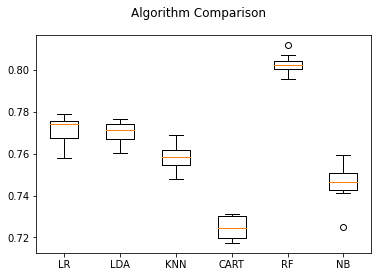

In [ ]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


It is very obvious that Random Forest has the best performance. Other models seems subpar.

### Model Training, Hyperparameter Tuning, Metrics

Let's first talk about whether to use Classifier or Regressor. In a classification RF, each tree's prediction is a class label. The final RF prediction will take a majority vote over these predictions. In a regression RF, each tree's prediction is a numeric value. The final RF prediction will take the average over these predictions.

For our case, we're predicting mortality, which is a binary classification problem. I understand RFregressor works too in this situation by setting to numeric value, but intuition would be that RFclassifier is faster.

Also, considering data is discrete (binary 0/1), instead of continuous. RandomForestRegressor supports continuous format while Classifier supports discrete format. In this case, going back to the problem per se (as it is a classification problem), I would go with Classifier.

In [ ]:
# Let's try a random forest model first with my initial hyperparameters
rf_model = RandomForestClassifier(n_estimators=20,criterion='gini',\
                                  random_state=None, max_features = 'auto',\
                                  max_samples=0.5)

# Fit the random forest to the data
rf_model.fit(X_train_scaled, y_train)
test_probs = rf_model.predict_proba(X_test_scaled)
test_probs = test_probs[:,1]

roc_value = roc_auc_score(y_test, test_probs)
print('ROC value is {:.3f}'.format(roc_value))

ROC value is 0.797


Looking good. Now we want to perform hyperparameter tuning to find the best parameters. Here are the parameters that I'm specifically looking at: criterion, n_estimators, random_state, max_features, and then max_samples

In [ ]:
# Find the best parameters for the random forest
params = {'criterion':['entropy','gini'],'n_estimators':[20, 40, 60, 100],
          'random_state':[None, 0],'max_features':['log2','auto'],
          'max_samples':[0.5,None]}

model = RandomForestClassifier()
grid_search = GridSearchCV(model,params,cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'max_samples': None,
 'n_estimators': 100,
 'random_state': 0}

In [ ]:
# Retain the model with the best parameters
rf_model = RandomForestClassifier(n_estimators=100,criterion='entropy',\
                                  random_state=0, max_features = 'log2',\
                                  max_samples=None)

# Fit the random forest to the data
rf_model.fit(X_train_scaled, y_train)

test_probs = rf_model.predict_proba(X_test_scaled)
test_probs = test_probs[:,1]

roc_value = roc_auc_score(y_test, test_probs)
print('ROC value is {:.3f}'.format(roc_value))

ROC value is 0.817


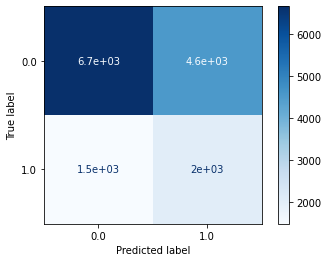

In [ ]:
# Plot confusion matrix to show the performance of selected model
y_pred = rf_model.predict(X_test)
plot_confusion_matrix(rf_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


In [ ]:
# Now that's try gradient boosting to see if it can improve the model performance

# Find the best parameters for the gradient bossting classifier
params = {'n_estimators':[20, 40, 60, 100], 'learning_rate':[0.1, 0.2, 0.5, 1],
          'random_state':[None, 0],'max_depth':[1, 2, 5, 10]}

model = GradientBoostingClassifier()
grid_search = GridSearchCV(model,params,cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'random_state': 0}

In [ ]:
# Retrain the gradient bossting with the best parameters
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=0,\
                                  max_depth = 5, learning_rate = 0.1)

# Fit the random forest to the data
gb_model.fit(X_train_scaled, y_train)
test_probs_gb = gb_model.predict_proba(X_test_scaled)
test_probs_gb = test_probs_gb[:,1]

roc_value = roc_auc_score(y_test, test_probs_gb)
print('ROC value is {:.3f}'.format(roc_value))

ROC value is 0.821


From here, hyperparameter tuning is completed. We could do more with more time, but we are satisfied with a 0.816 ROC score for the random forest and 0.821 for the gradient boosting.

Now let's do analysis from our ROC score, starting a ROC curve.

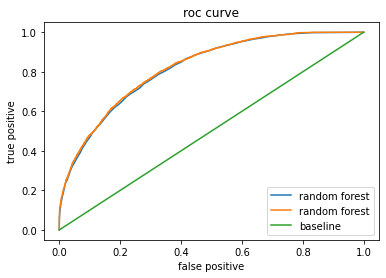

In [ ]:
# Plot ROC curves for random forest and gradient boosting
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, test_probs_gb)
plt.plot(fpr, tpr, label='random forest')
plt.plot(fpr_gb, tpr_gb, label='gradient boost')
plt.plot([0,1], [0,1], label='baseline')
plt.title('roc curve')
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.legend()

### Feature Visualization, K-Folds on ROC curve

It's always more relatable to see feature importance. Let's calculate feature importance from our model and then visualize them using our fitted model.

In [ ]:
def calc_feature_importances(model,feature_names,num_to_show):

    """
    Extract essential features from datasets

    Parameters
    ----------
    model: model()
      model from sklearn
    feature_names: str
      Name of the columns for selected features
    num_to_show: int
      Number of features to display

    Returns
    -------
    None
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feature_name = feature_names[indices[i]]
        ranked_feats.append(feature_name)
    RF_ranking = {'Feat Index':[], 'Feature':[], 'Importance':[]}
    RF_ranking['Feat Index'].extend(indices)
    RF_ranking['Feature'].extend(ranked_feats)
    RF_ranking['Importance'].extend(np.sort(importances)[::-1])

    RF_ranking = pd.DataFrame(RF_ranking)
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',title='RF Feature Importance', figsize=(10,7))
    plt.show()
    return

,Feat Index,Feature,Importance
0,11,num_labevent,0.127030
1,5,length_of_stay,0.114088
2,6,num_prescription,0.101923
3,0,num_diagnosis,0.099602
4,12,num_noteevent,0.096960
5,8,num_microbioevent,0.093416
6,9,num_cptevent,0.089360
7,10,num_daytimeevent,0.077925
8,4,ICU_stay,0.056007
9,7,num_procedureevent,0.044587


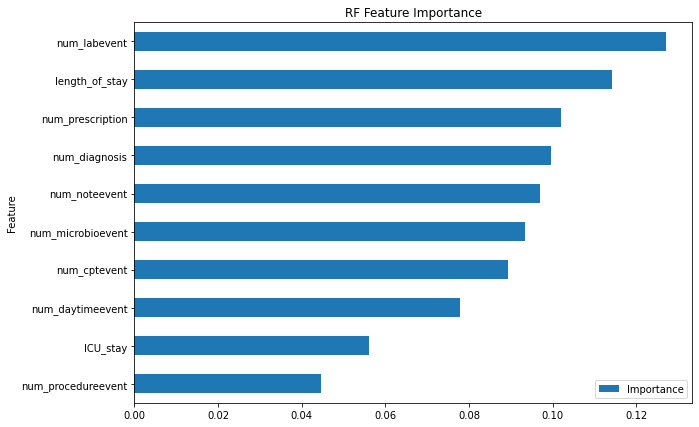

In [ ]:
# Instantiate a random forest, fit it to the data and then run the function to calculate feature importance
top_feats = 10
calc_feature_importances(rf_model,model_matrix.columns,top_feats)

Now it'd be more accurate if we use all samples by k-fold and then generalize the error. The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

0.13730824199298872
[0.8134573244746751, 0.8035480856877852, 0.8162642590370126, 0.808882507842891, 0.8108052991200345, 0.8198925154651272, 0.8182281030893271, 0.8161801894534781, 0.8125459896983076, 0.8211294480530446]


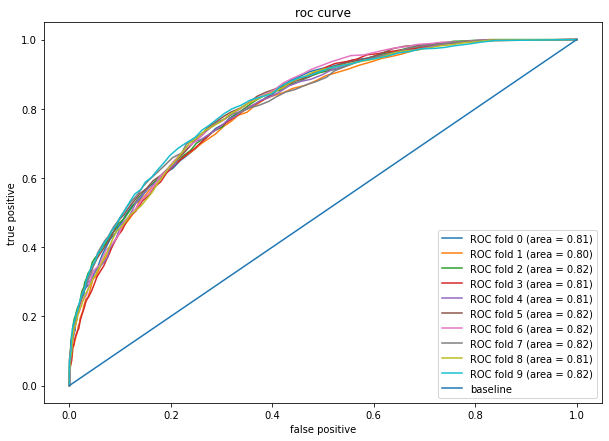

In [ ]:
# Plot ROC curves on different folds
kf = KFold(n_splits=10)

mse_folds = []
rf_errors = []
roc_values = []

i = 0
plt.figure(figsize=(10,7))
for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
    # Split training and validation sets for each fold
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Fit model to the training data for this iteration
    rf_model.fit(X_fold_train,y_fold_train)

    # Get predictions for the validation fold and calculate mse
    val_preds = rf_model.predict_proba(X_fold_val)[:,1]
    mse_val = mean_squared_error(y_fold_val,val_preds)
    roc_score = roc_auc_score(y_fold_val, val_preds)
    mse_folds.append(mse_val)
    roc_values.append(roc_score)

    fpr, tpr, thresholds = roc_curve(y_fold_val, val_preds)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i, roc_score))

    i += 1

plt.plot([0,1], [0,1], label='baseline')
plt.title('roc curve')
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.legend()

print(np.mean(mse_folds))
print(roc_values)

Conclusion from K-fold (ROC curve and MSE value): every piece of training data have been tested, and no obvious overfitting is observed.

In [ ]:
# Display MSE(Mean Square Error)
mse_folds

[0.1384688666553647,
 0.13898917234277677,
 0.1342460728138267,
 0.13778937372823877,
 0.136872042109428,
 0.13895374782701536,
 0.13825695049865602,
 0.13747050518752982,
 0.13768847533725223,
 0.13434721342979877]

You can see that MSE value are relatively small too (roughly 0.1). That makes sense since there are definitely space to improve, but 0.1 is definitely not large.

So far we have covered random forest classifier from model comparison, model set up, hyperparameter tuning, metrics evaluation, and then visualization.

## Suggestions

If we want to look at MSE values, as we discussed above, they are definitely not that large; but that doesn't mean it is optimal. Also, ROC score gives a 0.812 performance, which is also good but not optimal. We have a tremendous gap to fill before making this a reliable model on mortality predition using MIMIC data.

Let's discuss good stuff first. We did scaling using Standardizer packages, which helps to scale our data during our modeling. We not just put a simple Random Forest model, but also did GridSearch and KFold to find the best model. Moreover, we want to do cross validation to check on our ROC score, in that we make sure that our model is not overfitting.

You could picture our model being used on mortality prediction. We are assuming that data in the future does not have a drastic change from what we have so far. Going through the same process, ideally, we could have a >0.8 ROC score and a ~0.1 MSE value. It's definitely not optimal, since the accuracy looks good. However, a 0.8 ROC score will have problems too: if you're designing mortality prediction, you want a high precision, which is yet to be true in our model.

Let's talk about improvements from 3 perspectives: Feature selection, hyperparameter tuning, and Model fitting.

First of all, feature selection. We basically put all our features into the model. Later we run the feature importance selection, and it is obvious that some features, like numlabevents, have more weights than features like GENDER and admission type. It makes sense too! In reality you would expect minimal relevance between gender, or admission type, or marital status type and mortality. It makes sense to do a reverse feature engineering by deleting less relevant features. What I'm thinking is you could even introduce LASSO with a penalty factor to reduce the features. You could do PCA (Principal Component Analysis), but that might over reduce features since you want to keep some features as well.

Second, let's talk about hyperparameter tuning. We did perform a GridSearchCV to find best max_features, max_samples, criterions and n_estimators. However, there are much more attributes that we have not discussed. You would easily think one that's very important; min_sample_leaf. That closely correlates to the overfitting problem. If we do a min_sample_leaf versus MSE, chances are training set have decreasing MSE, while test set will increase as one point. We want to find a min_sample_leaf that's smaller than that point. This is just an example of other hyperparameters that we have not tuned yet.

Last, it would go to model fitting. There's not that much to be concerned other than potentials issues rising from KFold. A train/test split especially using KFold assumes our data are iid (independent and identically distributed). However, it might not be the case in our MIMIC sample. Just imagine how numlabevents and admission type are easily correlated. What do we do when they are not independent? I would say introduce a partial dependency model to our model too.

## Conclusion

Our goal for the model is two-fold: the model should be accurate enough for 1-year mortality prediction and the model is easy to implement. Our accuracy is at 80% which is acceptable. \

And it does not require expertise in keeping record of these patient features and feeding them into the model. In our final model, the number of lab events, the length of stay, the number of prescriptions, the number of note events, and the number of micro-events were of top importance in the prediction of mortality. As such, we recommend that the healthcare providers take prioritization in keeping track of these numbers with individual patients. \

Intuitively, the count of these events and procedures may not be finalized until a patient is discharged when the most accurate prediction can be generated. However, if we want to follow a patient's condition, it is not unnecessary to constantly update the patients’ condition and use the model prediction as a reference. The physician would have a better understanding of how the patient's illness may progress and decide if the patient needed closer monitoring during the hospital stay. It should be noted that when using the model, any actions taken as a consequence of the model prediction should not be taken into account when updating the prediction at a later time. For example, if a patient is held at the hospital for additional times because of a positive prediction (1 for death within a year) and the physician wanted to keep them under observation for longer, these extra days and the diagnostic tests that are performed within this period should not be added to the patient's existing record for prediction. \

At this stage, the robustness of the model was not tested for patient records generated under such modified behaviors due to a lack of intention when collecting the data. Also, as mentioned in the suggestion section, since some features are correlated while others aren't, there is a limit of model performance where a model of a single type may not be able to yield a valid result. Future improvement on the model would be to introduce other fitting techniques for a more comprehensive take on the problem.


##Reference

1. https://mimic.physionet.org/mimictables/d_items/
2. https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/notebooks/3_xgboosting.ipynb
3. https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
4. https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c